In [2]:
# Dataset for multi-modal inputs (ViT + CNN)
class DualInputDataset(Dataset):
    def __init__(self, vit_image_paths, cnn_image_paths, labels, vit_transform, cnn_transform):
        """
        Dataset for dual-input models (RGB + thermal)

        Args:
            vit_image_paths: List of paths to RGB images (ViT input)
            cnn_image_paths: List of paths to thermal images (CNN input)
            labels: List of corresponding labels
            vit_transform: Transform pipeline for ViT images
            cnn_transform: Transform pipeline for CNN images
        """
        self.vit_image_paths = vit_image_paths
        self.cnn_image_paths = cnn_image_paths
        self.labels = labels
        self.vit_transform = vit_transform
        self.cnn_transform = cnn_transform

        # Validate data alignment
        if len(vit_image_paths) != len(cnn_image_paths) or len(vit_image_paths) != len(labels):
            raise ValueError("Input lengths mismatch: ViT paths, CNN paths and labels must be equal")

    def __len__(self):
        """Returns total number of samples"""
        return len(self.labels)

    def __getitem__(self, idx):
        """Loads and transforms image pair, returns (vit_input, cnn_input, label)"""
        # Process RGB image for ViT
        vit_img = Image.open(self.vit_image_paths[idx]).convert('RGB')
        vit_tensor = self.vit_transform(vit_img)

        # Process thermal image for CNN
        cnn_img = Image.open(self.cnn_image_paths[idx])
        cnn_tensor = self.cnn_transform(cnn_img)

        # Convert label to tensor
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        return vit_tensor, cnn_tensor, label


In [4]:
def denormalize_tensor(tensor, mean, std):
    """Denormalize tensor using mean and std"""
    if tensor.dim() == 4:  # batch dimension
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return tensor
    else:
        return tensor * torch.tensor(std).view(-1, 1, 1) + torch.tensor(mean).view(-1, 1, 1)

def generate_augmented_images(image_paths, transform, output_dir, modality, num_copies=5):
    """
    Generate and save augmented images to disk
    Returns list of paths to augmented images
    """
    os.makedirs(output_dir, exist_ok=True)
    new_paths = []

    for path in image_paths:
        img = Image.open(path)
        base_name = os.path.splitext(os.path.basename(path))[0]

        for j in range(num_copies):
            # Apply transformation
            tensor = transform(img)

            # Denormalize for saving
            if modality == 'RGB':
                denorm_tensor = denormalize_tensor(
                    tensor,
                    [0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225]
                )
            else:  # thermal
                denorm_tensor = denormalize_tensor(
                    tensor,
                    [0.5],
                    [0.5]
                )

            # Convert to PIL and save
            if modality == 'RGB':
                pil_img = transforms.ToPILImage()(denorm_tensor)
            else:
                # Handle grayscale separately
                pil_img = transforms.ToPILImage()(denorm_tensor.squeeze(0))

            new_filename = f"{base_name}_aug{j}.jpg"
            new_path = os.path.join(output_dir, new_filename)
            pil_img.save(new_path)
            new_paths.append(new_path)

    return new_paths

In [7]:
# Prepare multimodal datasets for fusion model training
def prepare_fusion_data(vit_fire_dir, vit_non_fire_dir, cnn_fire_dir, cnn_non_fire_dir):
    print(f"\n{'='*50}")
    print("Preparing multimodal fusion dataset")
    print(f"ViT fire (RGB) directory: {vit_fire_dir}")
    print(f"ViT non-fire (RGB) directory: {vit_non_fire_dir}")
    print(f"CNN fire (thermal) directory: {cnn_fire_dir}")
    print(f"CNN non-fire (thermal) directory: {cnn_non_fire_dir}")

    # Normalizes filenames for matching across modalities
    def get_base_name(filename):
        base = os.path.splitext(filename)[0]  # Remove extension
        base = re.sub(r'^(RGB_|THERMAL_|IMG_|DSC_)', '', base)  # Remove prefixes
        return re.sub(r'[^a-zA-Z0-9]', '', base).lower()  # Standardize format

    # Process RGB images for ViT model
    vit_mapping = {}
    # Process fire RGB images
    if os.path.isdir(vit_fire_dir):
        print(f"Processing ViT fire images")
        for filename in os.listdir(vit_fire_dir):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            base_name = get_base_name(filename)
            vit_mapping[base_name] = {"path": os.path.join(vit_fire_dir, filename), "label": 1}

    # Process non-fire RGB images
    if os.path.isdir(vit_non_fire_dir):
        print(f"Processing ViT non-fire images")
        for filename in os.listdir(vit_non_fire_dir):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            base_name = get_base_name(filename)
            vit_mapping[base_name] = {"path": os.path.join(vit_non_fire_dir, filename), "label": 0}

    print(f"ViT images found: {len(vit_mapping)}")

    # Process thermal images for CNN model
    cnn_mapping = {}
    # Process fire thermal images
    if os.path.isdir(cnn_fire_dir):
        print(f"Processing CNN fire images")
        for filename in os.listdir(cnn_fire_dir):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            base_name = get_base_name(filename)
            cnn_mapping[base_name] = {"path": os.path.join(cnn_fire_dir, filename), "label": 1}

    # Process non-fire thermal images
    if os.path.isdir(cnn_non_fire_dir):
        print(f"Processing CNN non-fire images")
        for filename in os.listdir(cnn_non_fire_dir):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            base_name = get_base_name(filename)
            cnn_mapping[base_name] = {"path": os.path.join(cnn_non_fire_dir, filename), "label": 0}

    print(f"CNN images found: {len(cnn_mapping)}")

    # Match image pairs across modalities
    matched_pairs = []
    for key in set(vit_mapping.keys()) & set(cnn_mapping.keys()):  # Intersection of keys
        vit_data = vit_mapping[key]
        cnn_data = cnn_mapping[key]

        # Verify consistent labeling
        if vit_data["label"] != cnn_data["label"]:
            print(f"Label mismatch for {key}: ViT={vit_data['label']}, CNN={cnn_data['label']}")
            continue

        matched_pairs.append((vit_data["path"], cnn_data["path"], vit_data["label"]))

    print(f"Total matched pairs: {len(matched_pairs)}")

    # Analyze class distribution
    fire_pairs = [p for p in matched_pairs if p[2] == 1]
    non_fire_pairs = [p for p in matched_pairs if p[2] == 0]
    print(f"Fire pairs: {len(fire_pairs)}, Non-fire pairs: {len(non_fire_pairs)}")

    # Handle insufficient data scenarios
    if not matched_pairs:
        # Diagnostic output for debugging
        print("\nSample ViT keys:", list(vit_mapping.keys())[:5])
        print("Sample CNN keys:", list(cnn_mapping.keys())[:5])
        raise ValueError("No matching pairs found. Check filename patterns and directories.")

    # Balance classes if both present
    if fire_pairs and non_fire_pairs:
        n_per_class = min(len(fire_pairs), len(non_fire_pairs))
        all_pairs = fire_pairs[:n_per_class] + non_fire_pairs[:n_per_class]
        print(f"Balanced dataset: {n_per_class} per class")
    else:
        all_pairs = matched_pairs
        print("Using all available pairs (single class)")

    # Shuffle dataset
    np.random.shuffle(all_pairs)
    vit_paths, cnn_paths, labels = zip(*all_pairs)  # Unzip pairs

    # Stratified split into train/val/test (70/15/15)
    train_idx, test_idx = train_test_split(
        range(len(labels)),
        test_size=0.2,
        random_state=42,
        stratify=labels
    )
    train_idx, val_idx = train_test_split(
        train_idx,
        test_size=0.25,
        random_state=42,
        stratify=[labels[i] for i in train_idx]
    )

    # Create split indices
    vit_train = [vit_paths[i] for i in train_idx]
    cnn_train = [cnn_paths[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]

    vit_val = [vit_paths[i] for i in val_idx]
    cnn_val = [cnn_paths[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]

    vit_test = [vit_paths[i] for i in test_idx]
    cnn_test = [cnn_paths[i] for i in test_idx]
    test_labels = [labels[i] for i in test_idx]

    # Dataset statistics
    print(f"\nDataset splits:")
    print(f"Train: {len(vit_train)} pairs")
    print(f"Validation: {len(vit_val)} pairs")
    print(f"Test: {len(vit_test)} pairs")

    # Transformation pipelines
    # ViT (RGB) transforms
    vit_train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    vit_eval_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # CNN (thermal) transforms
    cnn_train_transform = v2.Compose([
        v2.RandomResizedCrop(size=(224, 224)),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Grayscale(num_output_channels=1),
        v2.Normalize(mean=[0.5], std=[0.5]),
    ])

    cnn_eval_transform = v2.Compose([
        v2.Resize(size=(224, 224)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Grayscale(num_output_channels=1),
        v2.Normalize(mean=[0.5], std=[0.5]),
    ])

    print("\nGenerating augmented training images...")
    num_aug_copies = 5  # Generate 5 augmented copies per original image

    # Create output directories
    processed_rgb_dir = "../dataset/processed/RGB"
    processed_thermal_dir = "../dataset/processed/thermal"

    # Generate augmented RGB images
    aug_rgb_paths = generate_augmented_images(
        vit_train,
        vit_train_transform,
        processed_rgb_dir,
        'RGB',
        num_aug_copies
    )

    # Generate augmented thermal images
    aug_thermal_paths = generate_augmented_images(
        cnn_train,
        cnn_train_transform,
        processed_thermal_dir,
        'thermal',
        num_aug_copies
    )

    # Combine original and augmented paths
    vit_train_combined = vit_train + aug_rgb_paths
    cnn_train_combined = cnn_train + aug_thermal_paths
    train_labels_combined = train_labels + train_labels * num_aug_copies

    # Verify new sizes
    print(f"\nAugmented dataset sizes:")
    print(f"Original RGB training images: {len(vit_train)}")
    print(f"Original thermal training images: {len(cnn_train)}")
    print(f"Augmented RGB images: {len(aug_rgb_paths)}")
    print(f"Augmented thermal images: {len(aug_thermal_paths)}")
    print(f"RGB Combined training set: {len(vit_train_combined)}")
    print(f"Thermal Combined training set: {len(cnn_train_combined)}")
    print(f"Combined training set: {len(train_labels_combined)} pairs")

    # Create new transforms for training (only normalization since augmentation is pre-generated)
    vit_train_transform_final = transforms.Compose([
        transforms.Resize(224),  # Ensure correct size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    cnn_train_transform_final = v2.Compose([
        v2.Resize(224),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Grayscale(num_output_channels=1),
        v2.Normalize(mean=[0.5], std=[0.5]),
    ])

    # Create datasets
    train_dataset = DualInputDataset(
        vit_train_combined,
        cnn_train_combined,
        train_labels_combined,
        vit_train_transform_final,
        cnn_train_transform_final
    )

    val_dataset = DualInputDataset(
        vit_val,
        cnn_val,
        val_labels,
        vit_eval_transform,
        cnn_eval_transform
    )

    test_dataset = DualInputDataset(
        vit_test,
        cnn_test,
        test_labels,
        vit_eval_transform,
        cnn_eval_transform
    )

    # Create dataloaders
    batch_size = 16
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=4
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=4
    )

    return train_dataloader, val_dataloader, test_dataloader

In [9]:
# Dataset paths
vit_fire_dir = "../dataset/raw/RGB/fire"
vit_non_fire_dir = "../dataset/raw/RGB/no_fire"
cnn_fire_dir = "../dataset/raw/thermal/fire"
cnn_non_fire_dir = "../dataset/raw/thermal/no_fire"

train_loader, val_loader, test_loader = prepare_fusion_data(
    vit_fire_dir, vit_non_fire_dir, cnn_fire_dir, cnn_non_fire_dir
)


Preparing multimodal fusion dataset
ViT fire (RGB) directory: dataset/raw/RGB/fire
ViT non-fire (RGB) directory: dataset/raw/RGB/no_fire
CNN fire (thermal) directory: dataset/raw/thermal/fire
CNN non-fire (thermal) directory: dataset/raw/thermal/no_fire
Processing ViT fire images
Processing ViT non-fire images
ViT images found: 529
Processing CNN fire images
Processing CNN non-fire images
CNN images found: 417
Total matched pairs: 417
Fire pairs: 301, Non-fire pairs: 116
Balanced dataset: 116 per class

Dataset splits:
Train: 138 pairs
Validation: 47 pairs
Test: 47 pairs

Generating augmented training images...

Augmented dataset sizes:
Original training images: 138
Augmented RGB images: 690
Augmented thermal images: 690
ViT Combined training set: 828 pairs
CNN Combined training set: 828 pairs
Combined training set: 828 pairs


# Augmentation Test

In [4]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import numpy as np

# Function to denormalize and display tensors
def imshow_tensor(tensor, title=None, is_rgb=True):
    tensor = tensor.clone().detach()
    if is_rgb:
        # RGB denormalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        tensor = tensor * std + mean
        tensor = tensor.clamp(0, 1)
        image = tensor.numpy().transpose(1, 2, 0)
        plt.imshow(image)
    else:
        # Thermal denormalization
        tensor = tensor * 0.5 + 0.5
        image = tensor.squeeze(0).numpy()
        plt.imshow(image, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')

# Function to test RGB augmentations
def test_rgb_augmentation(image_path, transform, n_samples=5):
    image = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(20, 4))

    # Original image
    plt.subplot(1, n_samples + 1, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis('off')

    # Augmented images
    for i in range(n_samples):
        transformed = transform(image)
        plt.subplot(1, n_samples + 1, i + 2)
        imshow_tensor(transformed, title=f"Aug {i+1}", is_rgb=True)
    plt.tight_layout()
    plt.show()

# Function to test thermal augmentations
def test_thermal_augmentation(image_path, transform, n_samples=5):
    image = Image.open(image_path)
    plt.figure(figsize=(20, 4))

    # Original image
    plt.subplot(1, n_samples + 1, 1)
    plt.imshow(np.array(image), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Augmented images
    for i in range(n_samples):
        transformed = transform(image)
        plt.subplot(1, n_samples + 1, i + 2)
        imshow_tensor(transformed, title=f"Aug {i+1}", is_rgb=False)
    plt.tight_layout()
    plt.show()

In [12]:
# ViT (RGB) augmentation pipeline
vit_train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# CNN (thermal) augmentation pipeline
cnn_train_transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Grayscale(num_output_channels=1),
    v2.Normalize(mean=[0.5], std=[0.5]),
])

Testing ViT (RGB) Augmentations:


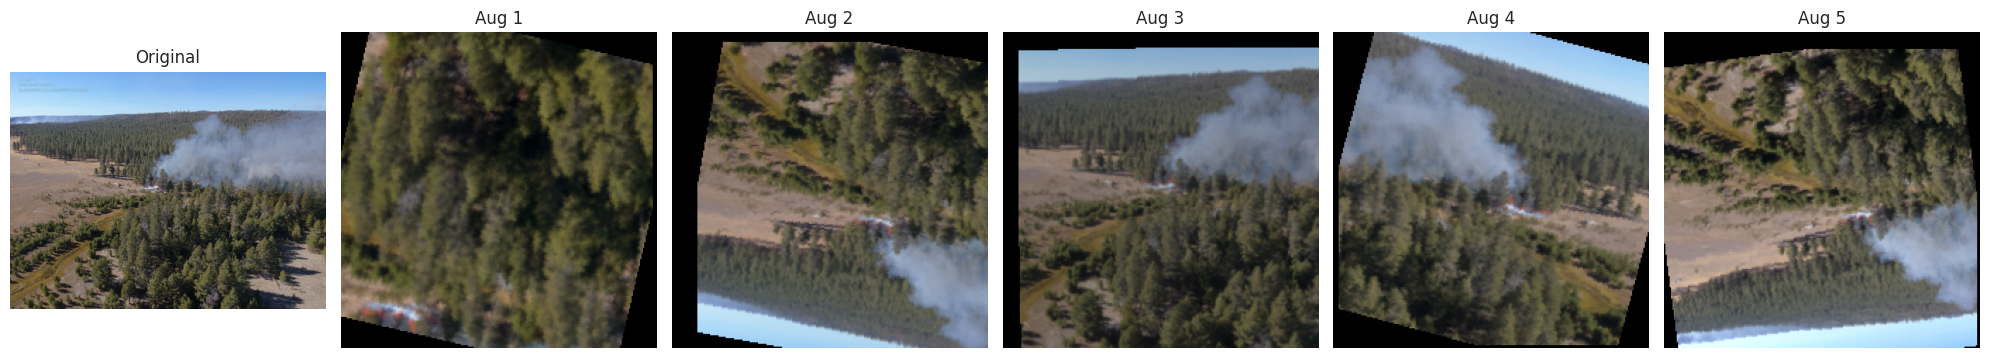


Testing CNN (Thermal) Augmentations:


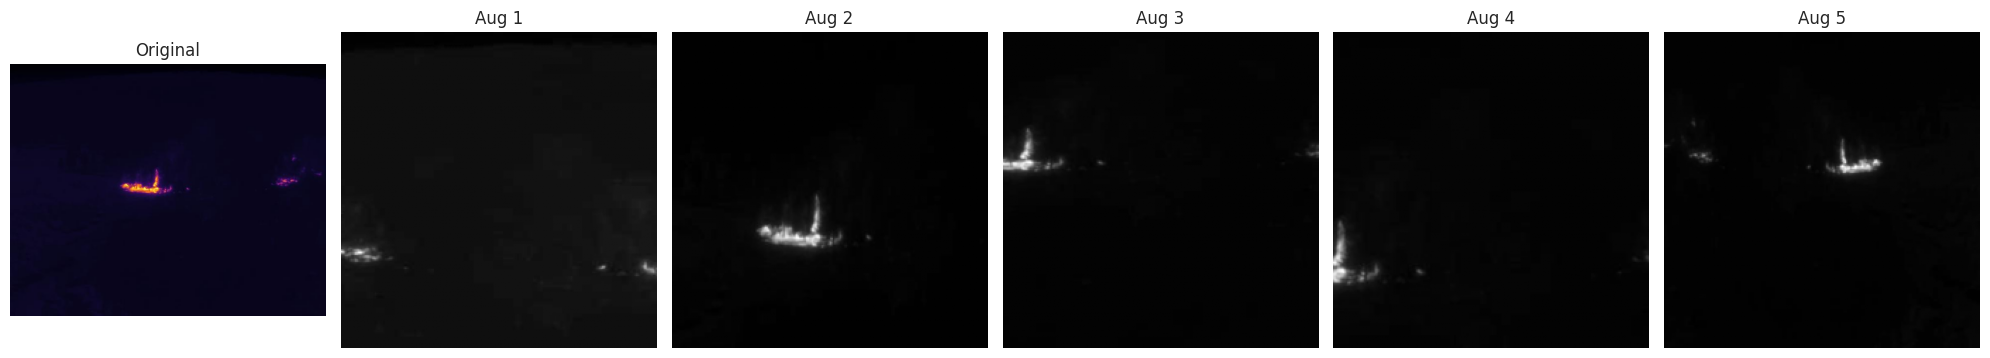

In [13]:
if __name__ == "__main__":
    # Replace with actual paths to your test images
    rgb_sample_path = "dataset/RGB/fire/00008.JPG"
    thermal_sample_path = "dataset/thermal/fire/00008.JPG"

    print("Testing ViT (RGB) Augmentations:")
    test_rgb_augmentation(rgb_sample_path, vit_train_transform)

    print("\nTesting CNN (Thermal) Augmentations:")
    test_thermal_augmentation(thermal_sample_path, cnn_train_transform)

# OG Code

In [ ]:
# Dataset for multi-modal inputs (ViT + CNN)
class DualInputDataset(Dataset):
    def __init__(self, vit_image_paths, cnn_image_paths, labels, vit_transform, cnn_transform):
        """
        Dataset for dual-input models (RGB + thermal)

        Args:
            vit_image_paths: List of paths to RGB images (ViT input)
            cnn_image_paths: List of paths to thermal images (CNN input)
            labels: List of corresponding labels
            vit_transform: Transform pipeline for ViT images
            cnn_transform: Transform pipeline for CNN images
        """
        self.vit_image_paths = vit_image_paths
        self.cnn_image_paths = cnn_image_paths
        self.labels = labels
        self.vit_transform = vit_transform
        self.cnn_transform = cnn_transform

        # Validate data alignment
        if len(vit_image_paths) != len(cnn_image_paths) or len(vit_image_paths) != len(labels):
            raise ValueError("Input lengths mismatch: ViT paths, CNN paths and labels must be equal")

    def __len__(self):
        """Returns total number of samples"""
        return len(self.labels)

    def __getitem__(self, idx):
        """Loads and transforms image pair, returns (vit_input, cnn_input, label)"""
        # Process RGB image for ViT
        vit_img = Image.open(self.vit_image_paths[idx]).convert('RGB')
        vit_tensor = self.vit_transform(vit_img)

        # Process thermal image for CNN
        cnn_img = Image.open(self.cnn_image_paths[idx])
        cnn_tensor = self.cnn_transform(cnn_img)

        # Convert label to tensor
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        return vit_tensor, cnn_tensor, label

In [ ]:
# Prepare multimodal datasets for fusion model training
def prepare_fusion_data(vit_fire_dir, vit_non_fire_dir, cnn_fire_dir, cnn_non_fire_dir):
    print(f"\n{'='*50}")
    print("Preparing multimodal fusion dataset")
    print(f"ViT fire (RGB) directory: {vit_fire_dir}")
    print(f"ViT non-fire (RGB) directory: {vit_non_fire_dir}")
    print(f"CNN fire (thermal) directory: {cnn_fire_dir}")
    print(f"CNN non-fire (thermal) directory: {cnn_non_fire_dir}")

    # Normalizes filenames for matching across modalities
    def get_base_name(filename):
        base = os.path.splitext(filename)[0]  # Remove extension
        base = re.sub(r'^(RGB_|THERMAL_|IMG_|DSC_)', '', base)  # Remove prefixes
        return re.sub(r'[^a-zA-Z0-9]', '', base).lower()  # Standardize format

    # Process RGB images for ViT model
    vit_mapping = {}
    # Process fire RGB images
    if os.path.isdir(vit_fire_dir):
        print(f"Processing ViT fire images")
        for filename in os.listdir(vit_fire_dir):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            base_name = get_base_name(filename)
            vit_mapping[base_name] = {"path": os.path.join(vit_fire_dir, filename), "label": 1}

    # Process non-fire RGB images
    if os.path.isdir(vit_non_fire_dir):
        print(f"Processing ViT non-fire images")
        for filename in os.listdir(vit_non_fire_dir):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            base_name = get_base_name(filename)
            vit_mapping[base_name] = {"path": os.path.join(vit_non_fire_dir, filename), "label": 0}

    print(f"ViT images found: {len(vit_mapping)}")

    # Process thermal images for CNN model
    cnn_mapping = {}
    # Process fire thermal images
    if os.path.isdir(cnn_fire_dir):
        print(f"Processing CNN fire images")
        for filename in os.listdir(cnn_fire_dir):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            base_name = get_base_name(filename)
            cnn_mapping[base_name] = {"path": os.path.join(cnn_fire_dir, filename), "label": 1}

    # Process non-fire thermal images
    if os.path.isdir(cnn_non_fire_dir):
        print(f"Processing CNN non-fire images")
        for filename in os.listdir(cnn_non_fire_dir):
            if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue
            base_name = get_base_name(filename)
            cnn_mapping[base_name] = {"path": os.path.join(cnn_non_fire_dir, filename), "label": 0}

    print(f"CNN images found: {len(cnn_mapping)}")

    # Match image pairs across modalities
    matched_pairs = []
    for key in set(vit_mapping.keys()) & set(cnn_mapping.keys()):  # Intersection of keys
        vit_data = vit_mapping[key]
        cnn_data = cnn_mapping[key]

        # Verify consistent labeling
        if vit_data["label"] != cnn_data["label"]:
            print(f"Label mismatch for {key}: ViT={vit_data['label']}, CNN={cnn_data['label']}")
            continue

        matched_pairs.append((vit_data["path"], cnn_data["path"], vit_data["label"]))

    print(f"Total matched pairs: {len(matched_pairs)}")

    # Analyze class distribution
    fire_pairs = [p for p in matched_pairs if p[2] == 1]
    non_fire_pairs = [p for p in matched_pairs if p[2] == 0]
    print(f"Fire pairs: {len(fire_pairs)}, Non-fire pairs: {len(non_fire_pairs)}")

    # Handle insufficient data scenarios
    if not matched_pairs:
        # Diagnostic output for debugging
        print("\nSample ViT keys:", list(vit_mapping.keys())[:5])
        print("Sample CNN keys:", list(cnn_mapping.keys())[:5])
        raise ValueError("No matching pairs found. Check filename patterns and directories.")

    # Balance classes if both present
    if fire_pairs and non_fire_pairs:
        n_per_class = min(len(fire_pairs), len(non_fire_pairs))
        all_pairs = fire_pairs[:n_per_class] + non_fire_pairs[:n_per_class]
        print(f"Balanced dataset: {n_per_class} per class")
    else:
        all_pairs = matched_pairs
        print("Using all available pairs (single class)")

    # Shuffle dataset
    np.random.shuffle(all_pairs)
    vit_paths, cnn_paths, labels = zip(*all_pairs)  # Unzip pairs

    # Stratified split into train/val/test (70/15/15)
    train_idx, test_idx = train_test_split(
        range(len(labels)),
        test_size=0.2,
        random_state=42,
        stratify=labels
    )
    train_idx, val_idx = train_test_split(
        train_idx,
        test_size=0.25,
        random_state=42,
        stratify=[labels[i] for i in train_idx]
    )

    # Create split indices
    vit_train = [vit_paths[i] for i in train_idx]
    cnn_train = [cnn_paths[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]

    vit_val = [vit_paths[i] for i in val_idx]
    cnn_val = [cnn_paths[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]

    vit_test = [vit_paths[i] for i in test_idx]
    cnn_test = [cnn_paths[i] for i in test_idx]
    test_labels = [labels[i] for i in test_idx]

    # Dataset statistics
    print(f"\nDataset splits:")
    print(f"Train: {len(vit_train)} pairs")
    print(f"Validation: {len(vit_val)} pairs")
    print(f"Test: {len(vit_test)} pairs")

    # Transformation pipelines
    # ViT (RGB) transforms
    vit_train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    vit_eval_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # CNN (thermal) transforms
    cnn_train_transform = v2.Compose([
        v2.RandomResizedCrop(size=(224, 224)),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Grayscale(num_output_channels=1),
        v2.Normalize(mean=[0.5], std=[0.5]),
    ])

    cnn_eval_transform = v2.Compose([
        v2.Resize(size=(224, 224)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Grayscale(num_output_channels=1),
        v2.Normalize(mean=[0.5], std=[0.5]),
    ])

    # Create datasets
    train_dataset = DualInputDataset(
        vit_train, cnn_train, train_labels,
        vit_train_transform, cnn_train_transform
    )
    val_dataset = DualInputDataset(
        vit_val, cnn_val, val_labels,
        vit_eval_transform, cnn_eval_transform
    )
    test_dataset = DualInputDataset(
        vit_test, cnn_test, test_labels,
        vit_eval_transform, cnn_eval_transform
    )

    # Create dataloaders
    batch_size = 16
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                 shuffle=True, num_workers=4)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

    return train_dataloader, val_dataloader, test_dataloader

# Validation testing

In [13]:
# Dataset for multi-modal inputs (ViT + CNN)
class DualInputDataset(Dataset):
    def __init__(self, vit_image_paths, cnn_image_paths, labels, vit_transform, cnn_transform):
        """
        Dataset for dual-input models (RGB + thermal)

        Args:
            vit_image_paths: List of paths to RGB images (ViT input)
            cnn_image_paths: List of paths to thermal images (CNN input)
            labels: List of corresponding labels
            vit_transform: Transform pipeline for ViT images
            cnn_transform: Transform pipeline for CNN images
        """
        self.vit_image_paths = vit_image_paths
        self.cnn_image_paths = cnn_image_paths
        self.labels = labels
        self.vit_transform = vit_transform
        self.cnn_transform = cnn_transform

        # Validate data alignment
        if len(vit_image_paths) != len(cnn_image_paths) or len(vit_image_paths) != len(labels):
            raise ValueError("Input lengths mismatch: ViT paths, CNN paths and labels must be equal")

    def __len__(self):
        """Returns total number of samples"""
        return len(self.labels)

    def __getitem__(self, idx):
        """Loads and transforms image pair, returns (vit_input, cnn_input, label)"""
        # Process RGB image for ViT
        vit_img = Image.open(self.vit_image_paths[idx]).convert('RGB')
        vit_tensor = self.vit_transform(vit_img)

        # Process thermal image for CNN
        cnn_img = Image.open(self.cnn_image_paths[idx])
        cnn_tensor = self.cnn_transform(cnn_img)

        # Convert label to tensor
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        return vit_tensor, cnn_tensor, label

In [11]:
# Fusion Model combining ViT and CNN features
class FusionModel(pl.LightningModule):
    def __init__(self, vit_extractor, cnn_extractor, config=None, visuals=True):
        """
        Multimodal fusion model combining ViT (RGB) and CNN (thermal) features.

        Args:
            vit_extractor: Pretrained ViT feature extractor
            cnn_extractor: Pretrained CNN feature extractor
            config: Configuration dictionary for hyperparameters
            visuals: Enable advanced visualization metrics
        """
        super().__init__()
        # Configuration setup
        default_config = {
            "lr": 1e-3,                # Learning rate
            "weight_decay": 1e-4,      # L2 regularization
            "dropout_rate": 0.4,       # Dropout probability
            "hidden_dim": 512,         # Fusion layer dimension
            "pos_weight": 1.0          # Class imbalance weight
        }
        if config:
            default_config.update(config)  # Merge with user config
        self.config = default_config

        # Visualization settings
        self.visuals = visuals
        self.save_hyperparameters(ignore=["vit_extractor", "cnn_extractor"])

        # Feature extractors (frozen)
        self.vit_extractor = vit_extractor
        self.cnn_extractor = cnn_extractor

        # Freeze extractors to preserve learned features
        for param in self.vit_extractor.parameters():
            param.requires_grad = False
        for param in self.cnn_extractor.parameters():
            param.requires_grad = False

        # Fusion classifier network
        self.classifier = nn.Sequential(
            nn.Linear(768 + 512, self.config["hidden_dim"]),  # Combine features
            nn.ReLU(),                                        # Non-linearity
            nn.BatchNorm1d(self.config["hidden_dim"]),        # Stabilization
            nn.Dropout(self.config["dropout_rate"]),          # Regularization
            nn.Linear(self.config["hidden_dim"], 1)           # Binary output
        )

        # Loss function with class weighting
        self.criterion = nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor(self.config["pos_weight"])
        )

        # Core metrics
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')

        self.train_acc_history = []  # Store training accuracy per epoch
        self.val_acc_history = []    # Store validation accuracy per epoch

        # Advanced metrics for visualization
        if self.visuals:
            # F1 Scores
            self.train_f1 = F1Score(task='binary')
            self.val_f1 = F1Score(task='binary')
            self.test_f1 = F1Score(task='binary')

            # Precision metrics
            self.train_precision = Precision(task='binary')
            self.val_precision = Precision(task='binary')
            self.test_precision = Precision(task='binary')

            # Recall metrics
            self.train_recall = Recall(task='binary')
            self.val_recall = Recall(task='binary')
            self.test_recall = Recall(task='binary')

        # Storage for test visualizations
        self.test_preds = []    # Predicted labels
        self.test_targets = []  # Ground truth labels
        self.test_probs = []    # Prediction probabilities

    def forward(self, vit_input, cnn_input):
        """Forward pass through both feature extractors and fusion classifier"""
        # Extract features from both modalities
        vit_features = self.vit_extractor(vit_input)  # RGB features (768-dim)
        _, cnn_features = self.cnn_extractor(cnn_input, return_features=True)  # Thermal features (512-dim)

        # Concatenate features along channel dimension
        combined = torch.cat((vit_features, cnn_features), dim=1)
        return self.classifier(combined).squeeze(1)  # Remove extra dimension

    def training_step(self, batch, batch_idx):
        """Single training step with metrics calculation"""
        vit_imgs, cnn_imgs, labels = batch
        logits = self(vit_imgs, cnn_imgs)  # Forward pass
        loss = self.criterion(logits, labels)  # Compute loss

        # Convert to probabilities and predictions
        probs = torch.sigmoid(logits)
        preds = probs > 0.5  # Threshold at 0.5

        # Update metrics
        self.train_acc(preds, labels)
        if self.visuals:
            self.train_f1(preds, labels)
            self.train_precision(preds, labels)
            self.train_recall(preds, labels)

        # Log metrics
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        if self.visuals:
            self.log("train_f1", self.train_f1, on_step=False, on_epoch=True, prog_bar=True)
            self.log("train_precision", self.train_precision, on_step=False, on_epoch=True)
            self.log("train_recall", self.train_recall, on_step=False, on_epoch=True)

        return loss

    def on_train_epoch_start(self):
        """Reset training metrics at the beginning of each epoch"""
        self.train_acc.reset()
        if self.visuals:
            self.train_f1.reset()
            self.train_precision.reset()
            self.train_recall.reset()

    def on_validation_epoch_start(self):
        """Reset validation metrics at the beginning of each epoch"""
        self.val_acc.reset()
        if self.visuals:
            self.val_f1.reset()
            self.val_precision.reset()
            self.val_recall.reset()

    def validation_step(self, batch, batch_idx):
        """
        Validation step with proper model state handling

        Ensures:
        - Model is in evaluation mode
        - Gradients are disabled for efficiency
        - Metrics are properly synchronized across devices
        """
        # Set model to evaluation mode and disable gradients
        self.eval()
        with torch.no_grad():
            vit_imgs, cnn_imgs, labels = batch
            logits = self(vit_imgs, cnn_imgs)
            loss = self.criterion(logits, labels)
            probs = torch.sigmoid(logits)
            preds = probs > 0.5

        # Update metrics
        self.val_acc(preds, labels)
        if self.visuals:
            self.val_f1(preds, labels)
            self.val_precision(preds, labels)
            self.val_recall(preds, labels)

        # Log metrics with synchronization for distributed training
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("val_acc", self.val_acc, on_epoch=True, prog_bar=True, sync_dist=True)
        if self.visuals:
            self.log("val_f1", self.val_f1, on_epoch=True, prog_bar=True, sync_dist=True)
            self.log("val_precision", self.val_precision, on_epoch=True, sync_dist=True)
            self.log("val_recall", self.val_recall, on_epoch=True, sync_dist=True)

        return loss


    def test_step(self, batch, batch_idx):
        """Test step with metrics and data collection for visualization"""
        vit_imgs, cnn_imgs, labels = batch
        logits = self(vit_imgs, cnn_imgs)
        loss = self.criterion(logits, labels)
        probs = torch.sigmoid(logits)
        preds = probs > 0.5

        # Update metrics
        self.test_acc(preds, labels)
        if self.visuals:
            self.test_f1(preds, labels)
            self.test_precision(preds, labels)
            self.test_recall(preds, labels)

            # Store for visualization
            self.test_preds.extend(preds.cpu().numpy())
            self.test_targets.extend(labels.cpu().numpy())
            self.test_probs.extend(probs.cpu().numpy())

        # Log metrics
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_acc", self.test_acc, on_epoch=True)
        if self.visuals:
            self.log("test_f1", self.test_f1, on_epoch=True)
            self.log("test_precision", self.test_precision, on_epoch=True)
            self.log("test_recall", self.test_recall, on_epoch=True)

        return loss

    def on_train_epoch_end(self):
        """Record training and validation accuracy at epoch end"""
        # Only record if metrics are available (handles incomplete epochs)
        if self.trainer.callback_metrics.get("train_acc") is not None:
            self.train_acc_history.append(self.trainer.callback_metrics["train_acc"].item())
        if self.trainer.callback_metrics.get("val_acc") is not None:
            self.val_acc_history.append(self.trainer.callback_metrics["val_acc"].item())

    def on_train_end(self):
        """Generate accuracy history plot after training completes"""
        if self.visuals and self.train_acc_history and self.val_acc_history:
            self.plot_accuracy_history()

    def plot_accuracy_history(self):
        """Plot training and validation accuracy over epochs"""
        plt.figure(figsize=(10, 6))
        epochs = range(1, len(self.train_acc_history) + 1)

        # Plot training and validation accuracy
        plt.plot(epochs, self.train_acc_history, 'bo-', label='Training Accuracy')
        plt.plot(epochs, self.val_acc_history, 'go-', label='Validation Accuracy')

        # Format plot
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1.05)  # Ensure accuracy range is visible
        plt.legend()
        plt.grid(True)

        # Save and show
        plt.savefig("Figures/accuracy_history.png")
        plt.show()

    def on_test_end(self):
        """Generate evaluation visualizations after testing completes"""
        if self.visuals and self.test_targets:
            self.generate_visualizations()
            # Clear stored data
            self.test_preds = []
            self.test_targets = []
            self.test_probs = []

    def generate_visualizations(self):
        """Create comprehensive evaluation plots and reports"""
        y_true = np.array(self.test_targets)
        y_pred = np.array(self.test_preds)
        y_probs = np.array(self.test_probs)

        # 1. Classification Report
        print("\n" + "="*50)
        print("Classification Report:")
        print(classification_report(y_true, y_pred, target_names=["Non-Fire", "Fire"]))

        # 2. Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Non-Fire', 'Fire'],
                    yticklabels=['Non-Fire', 'Fire'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.savefig("Figures/confusion_matrix.png")
        plt.show()

        # 3. ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig("Figures/roc_curve.png")
        plt.show()

        # 4. Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_true, y_probs)
        avg_precision = np.mean(precision)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2,
                 label=f'Precision-Recall (Avg Precision = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.savefig("Figures/precision_recall_curve.png")
        plt.show()

        # 5. Probability Distribution
        plt.figure(figsize=(10, 6))
        df = pd.DataFrame({
            'Probability': y_probs,
            'Class': ['Fire' if t == 1 else 'Non-Fire' for t in y_true]
        })
        sns.histplot(
            data=df,
            x='Probability', hue='Class', element='step', stat='density',
            common_norm=False, bins=20, palette=['red', 'green']
        )
        plt.title('Predicted Probability Distribution')
        plt.axvline(0.5, color='black', linestyle='--')
        plt.savefig("Figures/probability_distribution.png")
        plt.show()

    def configure_optimizers(self):
        """Configure optimizer and learning rate scheduler"""
        optimizer = torch.optim.AdamW(
            self.classifier.parameters(),  # Only optimize fusion classifier
            lr=self.config["lr"],
            weight_decay=self.config["weight_decay"]
        )

        # Learning rate scheduler (monitors validation accuracy)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',       # Maximize validation accuracy
            factor=0.5,       # Reduce LR by half
            patience=3,       # Wait 3 epochs without improvement
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_acc",  # Track validation accuracy
                "frequency": 1          # Check every epoch
            }
        }

In [12]:
# Training function for multimodal fusion model
def train_fusion_model(vit_extractor, cnn_extractor, train_loader, val_loader, test_loader,
                      max_epochs, config=None, visuals=True):
    """
    End-to-end training pipeline for multimodal fusion model with enhanced validation.

    Args:
        vit_extractor: Pretrained ViT feature extractor
        cnn_extractor: Pretrained CNN feature extractor
        max_epochs: Maximum training epochs
        config: Hyperparameter configuration dictionary
        visuals: Enable advanced evaluation metrics

    Returns:
        model: Trained fusion model
        test_results: Test performance metrics
    """

    # Initialize fusion model
    print("Initializing fusion model...")
    model = FusionModel(
        vit_extractor=vit_extractor,
        cnn_extractor=cnn_extractor,
        config=config,
        visuals=visuals
    )

    # Validate dataloaders
    print("\nValidating dataloaders:")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader) if val_loader is not None else 0}")
    print(f"Test batches: {len(test_loader)}")

    # Check for empty validation loader
    if val_loader is None or len(val_loader) == 0:
        print("\nWARNING: Validation loader is empty. Switching to test-only mode")
        val_loader = None
        monitor_metric = "train_acc"
        callbacks = []
    else:
        monitor_metric = "val_acc"
        # Configure training callbacks
        callbacks = [
            # Early stopping based on validation accuracy
            pl.callbacks.EarlyStopping(
                monitor=monitor_metric,
                patience=5,
                mode="max"
            ),
            # Model checkpointing
            pl.callbacks.ModelCheckpoint(
                monitor=monitor_metric,
                mode="max",
                filename="best_fusion_model",
                save_top_k=1,
                save_last=True
            ),
            # Learning rate monitor
            pl.callbacks.LearningRateMonitor(logging_interval='epoch')
        ]

    # Create PyTorch Lightning trainer with validation enhancements
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="auto",        # Automatic hardware selection
        devices="auto",            # Use available devices
        log_every_n_steps=5,       # Log metrics every 5 batches
        callbacks=callbacks,
        enable_progress_bar=True,
        check_val_every_n_epoch=1,  # Validate every single epoch
        num_sanity_val_steps=2,     # Run 2 validation batches before training starts
        deterministic=True,         # Ensure reproducible results
        enable_model_summary=True
    )

    # Train the model with explicit validation loader
    print("\nStarting fusion model training...")
    trainer.fit(
        model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader  # Explicit validation loader
    )

    # Load best checkpoint based on validation accuracy
    if val_loader is not None and len(val_loader) > 0:
        print("\nLoading best checkpoint...")
        best_model_path = trainer.checkpoint_callback.best_model_path
        if best_model_path:
            model = FusionModel.load_from_checkpoint(
                best_model_path,
                vit_extractor=vit_extractor,
                cnn_extractor=cnn_extractor,
                config=config,
                visuals=visuals
            )

    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_results = trainer.test(model, test_loader)

    return model, test_results

# ViT Testing

In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import vit_b_16, ViT_B_16_Weights
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedShuffleSplit
from torchmetrics import Accuracy
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import shutil

In [20]:
# Enhanced Data Preparation with Stratified Splitting
class FireDataset(pl.LightningDataModule):
    def __init__(self, data_dir, augmented_dir,
                 batch_size=32, num_workers=4, train_augmented_multiplicity=4,
                 regenerate=False):
        """
        Custom PyTorch Lightning DataModule for fire detection dataset.

        Args:
            data_dir: Root directory containing original image dataset
            augmented_dir: Directory to save processed images
            batch_size: Number of samples per batch
            num_workers: Parallel threads for data loading
            train_augmented_multiplicity: Multiplier for training data augmentation
            regenerate: Force regeneration of augmented dataset
        """
        super().__init__()
        self.data_dir = data_dir
        self.augmented_dir = augmented_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_augmented_multiplicity = train_augmented_multiplicity
        self.regenerate = regenerate
        self.classes = None
        self.transform = None
        self.augment = None
        self.class_counts = None
        self.split_sizes = None

    def setup(self, stage=None):
        """Prepares datasets and saves augmented images"""
        # Define transforms
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.augment = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Load base dataset
        base_dataset = datasets.ImageFolder(root=self.data_dir, transform=None)
        self.classes = base_dataset.classes
        targets = [s[1] for s in base_dataset.samples]
        filenames = [s[0] for s in base_dataset.samples]

        # Create splits: 70% train, 15% val, 15% test
        sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
        train_idx, temp_idx = next(sss1.split(np.zeros(len(targets)), targets))

        temp_targets = [targets[i] for i in temp_idx]
        sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
        val_idx, test_idx = next(sss2.split(np.zeros(len(temp_targets)), temp_targets))

        # Map back to original indices
        val_idx = temp_idx[val_idx]
        test_idx = temp_idx[test_idx]

        # Calculate class distribution for training set
        train_targets = [targets[i] for i in train_idx]
        self.class_counts = Counter(train_targets)
        self.split_sizes = {
            'train': len(train_idx),
            'val': len(val_idx),
            'test': len(test_idx)
        }

        print(f"Dataset sizes - Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")
        print(f"Class distribution in training set: {self.class_counts}")

        # Save augmented datasets
        self._save_augmented_dataset(base_dataset, filenames, train_idx, val_idx, test_idx)

        # Create datasets from saved images
        self.train_dataset = datasets.ImageFolder(
            root=os.path.join(self.augmented_dir, "train"),
            transform=self.transform,
            target_transform=lambda x: 1 - x  # Invert labels: fire=1, no_fire=0
        )
        self.val_dataset = datasets.ImageFolder(
            root=os.path.join(self.augmented_dir, "val"),
            transform=self.transform,
            target_transform=lambda x: 1 - x  # Invert labels
        )
        self.test_dataset = datasets.ImageFolder(
            root=os.path.join(self.augmented_dir, "test"),
            transform=self.transform,
            target_transform=lambda x: 1 - x  # Invert labels
        )

    def _save_augmented_dataset(self, base_dataset, filenames, train_idx, val_idx, test_idx):
        """Saves processed images to filesystem with overlap checking"""
        # Create output directories
        splits = {
            "train": (train_idx, self.augment, self.train_augmented_multiplicity),
            "val": (val_idx, self.transform, 1),
            "test": (test_idx, self.transform, 1)
        }

        # Create root augmented directory if needed
        os.makedirs(self.augmented_dir, exist_ok=True)

        # Check if regeneration is needed
        must_regenerate = self.regenerate
        if not must_regenerate:
            for split_name in splits.keys():
                split_dir = os.path.join(self.augmented_dir, split_name)
                if not os.path.exists(split_dir):
                    must_regenerate = True
                    print(f"Split directory {split_dir} not found, regenerating...")
                    break
                for class_name in self.classes:
                    class_dir = os.path.join(split_dir, class_name)
                    if not os.path.exists(class_dir) or len(os.listdir(class_dir)) == 0:
                        must_regenerate = True
                        print(f"Class directory {class_dir} empty or missing, regenerating...")
                        break
                if must_regenerate:
                    break

        if must_regenerate:
            print("Generating and saving augmented dataset...")
            # Clear existing directories
            for split_name in splits.keys():
                split_dir = os.path.join(self.augmented_dir, split_name)
                if os.path.exists(split_dir):
                    shutil.rmtree(split_dir)
                os.makedirs(split_dir)

            for split_name, (indices, transform, multiplicity) in splits.items():
                split_dir = os.path.join(self.augmented_dir, split_name)
                for class_name in self.classes:
                    class_dir = os.path.join(split_dir, class_name)
                    os.makedirs(class_dir, exist_ok=True)

                for idx in indices:
                    img, label = base_dataset[idx]
                    class_name = self.classes[label]
                    original_name = os.path.splitext(os.path.basename(filenames[idx]))[0]

                    for aug_idx in range(multiplicity):
                        # Apply transformations
                        transformed_img = transform(img)

                        # Convert back to PIL for saving
                        img_pil = self._tensor_to_pil(transformed_img)

                        # Save with unique filename
                        save_path = os.path.join(split_dir, class_name, f"{original_name}_aug{aug_idx}.jpg")
                        img_pil.save(save_path)
        else:
            print("Using existing augmented dataset")

    def _tensor_to_pil(self, tensor):
        """Converts normalized tensor back to PIL Image"""
        # Reverse normalization
        inverse_norm = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        tensor = inverse_norm(tensor)
        tensor = torch.clamp(tensor, 0, 1)
        tensor = tensor.mul(255).byte()
        return transforms.ToPILImage()(tensor.cpu())

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

In [21]:
# Vision Transformer (ViT) Feature Extractor with Classification Head
class FireFeatureExtractorViT(pl.LightningModule):
    def __init__(self, config=None):
        """
        Custom Vision Transformer model for fire detection with feature extraction capability.

        Args:
            config: Configuration dictionary with hyperparameters. Defaults to empty dict.
        """
        super().__init__()
        self.config = config or {}
        self.save_hyperparameters(config)  # Save config for checkpointing

        # Initialize with pretrained weights if specified, otherwise random initialization
        weights = ViT_B_16_Weights.IMAGENET1K_V1 if self.config.get("pretrained", True) else None
        self.vit = vit_b_16(weights=weights)

        # Freeze backbone parameters if requested (transfer learning)
        if self.config.get("freeze_backbone", True):
            for param in self.vit.parameters():
                param.requires_grad = False

        # Replace classification head with identity to output raw features (768-dim)
        self.vit.heads = nn.Identity()

        # Custom classification head for binary fire detection
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),  # Feature compression layer
            nn.ReLU(),            # Activation for non-linearity
            nn.BatchNorm1d(256),  # Normalization for stability
            nn.Dropout(self.config.get("dropout_rate", 0.5)),  # Regularization
            nn.Linear(256, 1)     # Binary classification output (fire/no-fire)
        )

        # Loss function with class weighting to handle imbalanced datasets
        self.criterion = nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor(self.config.get("pos_weight", 1.0))
        )

        # Accuracy metrics for different phases
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')

        # Track predictions and labels for debugging
        self.val_preds = []
        self.val_labels = []

    def forward(self, x):
        """Feature extraction pass - returns 768-dimensional embeddings"""
        return self.vit(x)

    def classify(self, x):
        """Full classification pass (features + classifier head)"""
        features = self.vit(x)  # Extract visual features
        return self.classifier(features).squeeze(1)  # Remove extra dimension

    def configure_optimizers(self):
        """Configure optimizer and learning rate scheduler"""
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.config.get("lr", 1e-4),                # Default learning rate
            weight_decay=self.config.get("weight_decay", 1e-4)  # L2 regularization
        )

        # Learning rate scheduler that reduces when validation accuracy plateaus
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',     # Monitor validation accuracy (maximize)
            factor=0.5,     # Reduce LR by half when triggered
            patience=3,     # Wait 3 epochs without improvement
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_acc",  # Watch validation accuracy
                "frequency": 1         # Check every epoch
            }
        }

    def training_step(self, batch, batch_idx):
        """Single training step with loss calculation and metrics logging"""
        images, labels = batch
        labels = labels.float()  # Convert to float for BCE loss

        # Forward pass through classifier
        outputs = self.classify(images)
        loss = self.criterion(outputs, labels)

        # Convert logits to binary predictions (threshold=0.5)
        preds = torch.sigmoid(outputs) > 0.5
        self.train_acc(preds, labels)  # Update accuracy metric

        # Log training metrics (step-level loss, epoch-level accuracy)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """Single validation step with metrics calculation"""
        images, labels = batch
        labels = labels.float()

        # Forward pass
        outputs = self.classify(images)
        loss = self.criterion(outputs, labels)

        # Calculate accuracy
        preds = torch.sigmoid(outputs) > 0.5
        self.val_acc(preds, labels)

        # Store for debugging
        self.val_preds.extend(preds.cpu().numpy())
        self.val_labels.extend(labels.cpu().numpy())

        # Log validation metrics (epoch-level only)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", self.val_acc, on_epoch=True, prog_bar=True)

        return loss

    def on_validation_epoch_end(self):
        """Debugging: Print validation predictions distribution"""
        if len(self.val_preds) > 0:
            pred_counts = Counter(self.val_preds)
            label_counts = Counter(self.val_labels)
            print(f"\nValidation Predictions: {pred_counts}")
            print(f"Validation Labels: {label_counts}")
            self.val_preds = []
            self.val_labels = []

    def test_step(self, batch, batch_idx):
        """Single test step for final evaluation"""
        images, labels = batch
        labels = labels.float()

        # Forward pass
        outputs = self.classify(images)
        loss = self.criterion(outputs, labels)

        # Calculate accuracy
        preds = torch.sigmoid(outputs) > 0.5
        self.test_acc(preds, labels)

        # Log test metrics
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_acc", self.test_acc, on_epoch=True)

        return loss

# Training Function
def train_feature_extractor(num_epochs):
    """
    Trains the fire feature extractor model end-to-end.

    Args:
        num_epochs: Number of training epochs

    Returns:
        model: Trained feature extractor model
        trainer: PyTorch Lightning trainer object
        data: Data module used for training
    """
    # Initialize data module with default batch size
    data = FireDataset(
        data_dir="../dataset/raw/RGB",
        augmented_dir="../dataset/vit",  # Use saved augmented images
        batch_size=32,
        regenerate=True,  # Force regeneration on first run
        train_augmented_multiplicity=5
    )
    data.setup()  # Prepare datasets and transformations

    # Calculate class imbalance weight for positive samples
    class_counts = list(data.class_counts.values())
    if len(class_counts) != 2:
        raise ValueError(f"Expected binary classification but found {len(class_counts)} classes")

    # Inverted labels: fire=1, no_fire=0
    # class_counts[0] = original fire count (now positive class)
    # class_counts[1] = original no_fire count (now negative class)
    pos_weight = class_counts[1] / class_counts[0]  # negative_count / positive_count
    print(f"Positive weight calculated: {pos_weight:.2f} (Class counts: {class_counts})")

    # Model configuration parameters
    config = {
        "lr": 1e-4,               # Learning rate
        "weight_decay": 1e-4,      # L2 regularization strength
        "freeze_backbone": True,   # Freeze ViT weights during training
        "pretrained": True,        # Use pretrained ViT weights
        "dropout_rate": 0.5,       # Dropout probability in classifier
        "pos_weight": pos_weight   # Class imbalance compensation
    }

    # Initialize model with configuration
    model = FireFeatureExtractorViT(config)

    # Model checkpoint callback - saves best model based on validation accuracy
    checkpoint = ModelCheckpoint(
        monitor="val_acc",         # Metric to monitor
        mode="max",                # Maximize validation accuracy
        save_top_k=1,              # Save only the best model
        filename="best_feature_extractor"  # Checkpoint filename
    )

    # Create PyTorch Lightning trainer
    trainer = pl.Trainer(
        max_epochs=num_epochs,    # Training duration
        callbacks=[checkpoint],    # Attach checkpoint callback
        accelerator="auto",        # Automatically select hardware (GPU/CPU)
        devices=1,                # Use single device
        log_every_n_steps=10,     # Log metrics every 10 batches
        enable_progress_bar=True,
        enable_model_summary=True,
        deterministic=True,       # For reproducibility
        check_val_every_n_epoch=1  # Validate every epoch
    )

    # Train the model
    trainer.fit(model, data)

    # Evaluate on test set after training
    test_result = trainer.test(model, dataloaders=data.test_dataloader())
    print(f"Test Accuracy: {test_result[0]['test_acc']:.4f}")

    return model, trainer, data

# Save Feature Extractor
def save_feature_extractor(trainer, path="feature_extractor.pth"):
    """
    Saves the trained feature extractor as a Lightning checkpoint.

    Preserves model weights, hyperparameters, and optimizer state.

    Args:
        trainer: Trainer instance containing the model
        path: Output file path for checkpoint
    """
    # Create directory if needed
    os.makedirs(os.path.dirname(path), exist_ok=True)

    # Save entire model state including metadata and optimizer
    trainer.save_checkpoint(path)
    print(f"Full Lightning checkpoint saved to {path}")

# Feature Extraction Function
def extract_features(model, dataloader):
    """
    Extracts feature vectors from images using the trained model.

    Args:
        model: Trained feature extractor model
        dataloader: DataLoader providing image batches

    Returns:
        features: 2D array of extracted features [n_samples, 768]
        labels: 1D array of corresponding labels
    """
    model.eval()  # Set model to evaluation mode
    features = []  # Storage for feature vectors
    labels = []    # Storage for corresponding labels

    with torch.no_grad():  # Disable gradient calculation
        for images, batch_labels in dataloader:
            # Move images to same device as model (GPU/CPU)
            images = images.to(model.device)

            # Extract features (768-dimensional vectors)
            batch_features = model(images)

            # Store results (move to CPU for numpy conversion)
            features.append(batch_features.cpu().numpy())
            labels.append(batch_labels.numpy())

    # Combine all batches into single arrays
    return np.concatenate(features), np.concatenate(labels)

# Visualization function for debugging
def visualize_augmentations(dataset, num_samples=5):
    """Visualize original and augmented images for debugging"""
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    # Original images
    for i in range(num_samples):
        img, _ = dataset[i]
        img = img.numpy().transpose(1, 2, 0)  # Convert to HWC
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Reverse normalization
        img = np.clip(img, 0, 1)
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original {i+1}")

    # Augmented images
    for i in range(num_samples):
        idx = len(dataset) // (i+1) - 1  # Get different augmented versions
        img, _ = dataset[idx]
        img = img.numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Augmented {i+1}")

    plt.tight_layout()
    plt.savefig("augmentation_samples.png")
    print("Saved augmentation samples to augmentation_samples.png")

Training feature extractor...
Dataset sizes - Train: 451, Val: 97, Test: 97
Class distribution in training set: Counter({0: 370, 1: 81})
Generating and saving augmented dataset...
Positive weight calculated: 4.57 (Class counts: [81, 370])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Dataset sizes - Train: 451, Val: 97, Test: 97
Class distribution in training set: Counter({0: 370, 1: 81})
Generating and saving augmented dataset...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | vit        | VisionTransformer | 85.8 M | train
1 | classifier | Sequential        | 197 K  | train
2 | criterion  | BCEWithLogitsLoss | 0      | train
3 | train_acc  | BinaryAccuracy    | 0      | train
4 | val_acc    | BinaryAccuracy    | 0      | train
5 | test_acc   | BinaryAccuracy    | 0      | train
---------------------------------------------------------
197 K     Trainable params
85.8 M    Non-trainable params
86.0 M    Total params
343.985   Total estimated model params size (MB)
161       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:04<00:00,  0.43it/s]
Validation Predictions: Counter({np.False_: 58, np.True_: 6})
Validation Labels: Counter({np.float32(1.0): 64})
Epoch 0: 100%|██████████| 71/71 [02:01<00:00,  0.58it/s, v_num=23, train_loss_step=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:04<00:00,  0.94it/s]
Validation Predictions: Counter({np.True_: 76, np.False_: 21})
Validation Labels: Counter({np.float32(1.0): 79, np.float32(0.0): 18})

Epoch 1: 100%|██████████| 71/71 [02:15<00:00,  0.52it/s, v_num=23, train_loss_step=0.429, val_loss=1.230, val_acc=0.969, train_loss_epoch=1.820, train_acc=0.841]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 4/4 [00:05<00:00,  0.77it/s]
Validation Predictions: Counter({np.True_: 76, np.False_: 21})
Validation Labels: Counter({np.float32(1.0): 79, np.float32(0.0): 18})

Epoch 2: 100%|██████████| 71/71 [02:12<00:00,  0.54it/s,

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 71/71 [02:10<00:00,  0.55it/s, v_num=23, train_loss_step=0.0671, val_loss=0.212, val_acc=0.990, train_loss_epoch=0.210, train_acc=0.994]
Dataset sizes - Train: 451, Val: 97, Test: 97
Class distribution in training set: Counter({0: 370, 1: 81})
Generating and saving augmented dataset...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    1.0
        test_loss           0.13416393101215363
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test Accuracy: 1.0000
Full Lightning checkpoint saved to Saved_Features/ViT_fire_feature_extractor.pth

Loading feature extractor for inference...

Extracting features from training dataset...
Extracted 2255 feature vectors (768-dim each)

Features ready for transfer learning or multi-model systems:
Feature vector shape: (768,)
Sample feature (first 10 values): [ 0.29905862 -0.12802218  0.38308504  0.22398052 -0.37318984  0.44413722


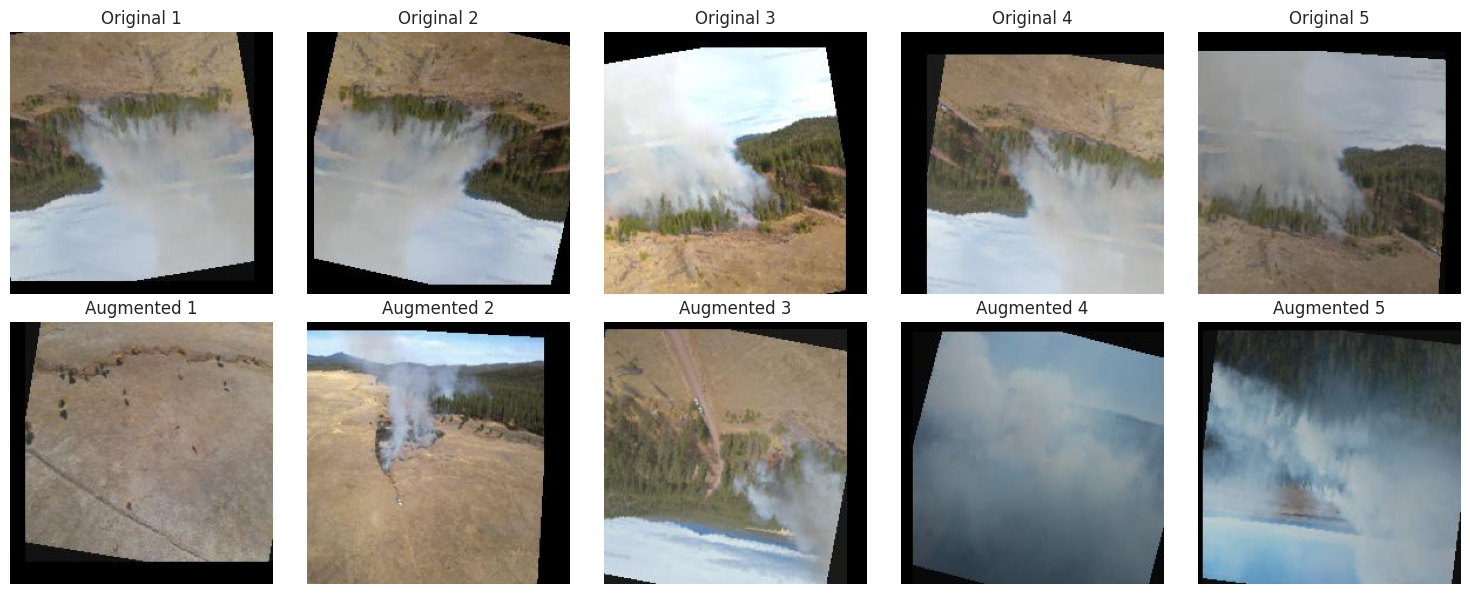

In [22]:
# --- TRAINING PIPELINE EXECUTION ---
if __name__ == "__main__":
    # Clear GPU memory cache to avoid out-of-memory errors
    torch.cuda.empty_cache()

    # Start performance timer
    start = time.time()

    # Step 1: Train the feature extractor model
    print("Training feature extractor...")
    trained_model, trainer, data = train_feature_extractor(num_epochs=10)

    # Step 2: Save the trained model for future use
    save_feature_extractor(trainer, "../Saved_Features/ViT_fire_feature_extractor.pth")

    # Step 3: Load the feature extractor (without classifier head)
    print("\nLoading feature extractor for inference...")
    feature_extractor = FireFeatureExtractorViT.load_from_checkpoint(
        "Saved_Features/ViT_fire_feature_extractor.pth"
    )
    feature_extractor.eval()  # Set to evaluation mode

    # Step 4: Extract feature vectors from training data
    print("\nExtracting features from training dataset...")
    train_features, train_labels = extract_features(
        feature_extractor,
        data.train_dataloader()
    )
    print(f"Extracted {len(train_features)} feature vectors (768-dim each)")

    # Step 5: Demonstrate feature usage for downstream models
    print("\nFeatures ready for transfer learning or multi-model systems:")
    print(f"Feature vector shape: {train_features[0].shape}")  # Should be (768,)
    print(f"Sample feature (first 10 values): {train_features[0][:10]}...")

    # Calculate and display execution time
    time_taken = time.time() - start
    print(f"\nTotal Execution Time: {time_taken:.2f} seconds ({time_taken / 60:.2f} minutes)")

    # Visualize augmentations for debugging
    visualize_augmentations(data.train_dataset)